# Machine Learning_Final Model

## Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import color maps
import matplotlib.cm as cm
import string
# import model related libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, _forest
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_auc_score, fbeta_score, classification_report, confusion_matrix, recall_score, accuracy_score, balanced_accuracy_score
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# import a function that convert items into a callable object
from operator import itemgetter
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_colwidth = 200
%matplotlib inline
%run functions.ipynb # import my functions from functions notebook

Stored 'my_stop_words' (list)


## Load Data

In [2]:
# load master dataframe with features ready to be transformed and used by the model
master = pd.read_csv('../Capstone 1/master.csv')
master.drop('Unnamed: 0',axis=1,inplace=True)
master.columns

Index(['SUBJECT_ID', 'HADM_ID', 'READMISSION_30DAYS', 'DISCHARGE_LOCATION',
       'INSURANCE', 'MARITAL_STATUS', 'GENDER', 'AGE', 'ETHNICITY_GRP',
       'CURR_SERVICE', 'NUM_PRESCRIPTION', 'LOS', 'HLOS_CL', 'LOS_RATIO', 'KD',
       'HP', 'PUL', 'UT', 'HIV', 'DB', 'MBD', 'TB', 'GA', 'HM', 'HEP', 'HO',
       'FR', 'TX', 'LA', 'AF', 'CB', 'PNE', 'HF', 'SP', 'WMCC', 'WCC',
       'WOCCMCC', 'WOMCC', 'WCCMCC', 'DRG_SEVERITY', 'DRG_MORTALITY', 'TEXT',
       'TEXT_CL', 'AGE_boxcox_lambda_opt', 'NUM_PRESCRIPTION_LOG', 'LOS_LOG',
       'LOS_boxcox_lambda_opt', 'HLOS_CL_LOG', 'HLOS_CL_boxcox_lambda_opt',
       'LOS_RATIO_LOG', 'LOS_RATIO_boxcox_lambda_opt'],
      dtype='object')

## Transform features using pipeline

As a preparation for building and evaluating the final model, all features need to be transformed and combined into a single dataframe

In [3]:
# using datapipeline tools DataFrameMapper to map each feature to the appropriate format before using it in the model
mapper = DataFrameMapper([
    ('TEXT', TfidfVectorizer(min_df=10, max_features=3000, lowercase=True, #ngram_range=(2, 2),
                             tokenizer=tokenizer_better, stop_words=my_stop_words, use_idf=True))
    ,('DISCHARGE_LOCATION', LabelEncoder())
    ,('INSURANCE',          LabelEncoder())
    ,('MARITAL_STATUS',     LabelEncoder())
    ,('ETHNICITY_GRP',      LabelEncoder())
    ,('CURR_SERVICE',       LabelEncoder())
    ,('GENDER',             LabelEncoder())
    ,('AGE_boxcox_lambda_opt',        None)
#    ,(['AGE'], KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))
    ,('NUM_PRESCRIPTION_LOG', None)
#    ,('LOS_LOG',                None)
    ,('LOS_boxcox_lambda_opt', None)
#    ,('HLOS_CL_LOG',               None)
    ,('HLOS_CL_boxcox_lambda_opt', None)
#    ,(['LOS_RATIO'], KBinsDiscretizer(n_bins=5, encode='onehot', strategy='quantile'))
#    ,('LOS_RATIO_LOG', None)
    ,('LOS_RATIO_boxcox_lambda_opt', None)
    ,('KD',                 None)
    ,('HP',                 None)
    ,('PUL',                None)
    ,('UT',                 None)
    ,('HIV',                None)
    ,('DB',                 None)
    ,('MBD',                None)
    ,('TB',                 None)
    ,('GA',                 None)
    ,('HM',                 None)
    ,('HF',                 None)
    ,('HEP',                None)
    ,('HO',                 None)
    ,('FR',                 None)
    ,('TX',                 None)
    ,('LA',                 None)
    ,('AF',                 None)
    ,('CB',                 None)
    ,('SP',                 None)
    ,('PNE',                None)
    ,('WMCC',               None)
    ,('WCC',                None)
    ,('WOCCMCC',            None)
    ,('WOMCC',              None)
    ,('WCCMCC',             None)
    ,('READMISSION_30DAYS', None)
#    ,('DRG_SEVERITY',       None)
#    ,('DRG_MORTALITY',      None)
], df_out=True)

In [4]:
# fit and transform the master dataset including discharge notes to return a final feature set
df = mapper.fit_transform(master)

In [5]:
df.shape

(8308, 3037)

In [6]:
df.columns[-40:]

Index(['TEXT_zofran', 'TEXT_zolpidem', 'TEXT_zosyn', 'DISCHARGE_LOCATION',
       'INSURANCE', 'MARITAL_STATUS', 'ETHNICITY_GRP', 'CURR_SERVICE',
       'GENDER', 'AGE_boxcox_lambda_opt', 'NUM_PRESCRIPTION_LOG',
       'LOS_boxcox_lambda_opt', 'HLOS_CL_boxcox_lambda_opt',
       'LOS_RATIO_boxcox_lambda_opt', 'KD', 'HP', 'PUL', 'UT', 'HIV', 'DB',
       'MBD', 'TB', 'GA', 'HM', 'HF', 'HEP', 'HO', 'FR', 'TX', 'LA', 'AF',
       'CB', 'SP', 'PNE', 'WMCC', 'WCC', 'WOCCMCC', 'WOMCC', 'WCCMCC',
       'READMISSION_30DAYS'],
      dtype='object')

## Balance positive and negative class

In [239]:
# shuffle the samples
df = df.sample(n = len(df), random_state = 42)
df = df.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test = df.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all = df.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.READMISSION_30DAYS.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.READMISSION_30DAYS.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.READMISSION_30DAYS.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df))
assert len(df) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 1246): 0.2768860353130016
Valid prevalence(n = 1246): 0.27046548956661315
Train all prevalence(n = 5816): 0.26667812929848694
all samples (n = 8308)


In [240]:
rows_pos = df_train_all.READMISSION_30DAYS == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.READMISSION_30DAYS.sum()/ len(df_train))

Train prevalence (n = 3102): 0.5


In [241]:
X_train_all = df_train.drop('READMISSION_30DAYS',axis=1)
X_valid_all = df_valid.drop('READMISSION_30DAYS',axis=1)
y_train_all = df_train.READMISSION_30DAYS
y_valid_all = df_valid.READMISSION_30DAYS

## Find the best C-value with L1 penalty with Logistic Regression

In [353]:
params = {'C': np.linspace(start = 0, stop = 2, num = 10)}

logistic = LogisticRegression(penalty='l2',solver='liblinear')

clf = GridSearchCV(logistic, param_grid=params,  scoring = "roc_auc", cv = 3, verbose =1, n_jobs = -1)

In [354]:
best_model = clf.fit(X_train_all, y_train_all)
print('Best C:', best_model.best_estimator_.get_params()['C'])
#cv_scores = best_model.cv_results_[best_model.cv_results_['mean_test_score']!='nan']
#print('Best avg. AUC :', np.mean(cv_scores))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.5s finished


Best C: 0.8888888888888888


## Create subsets of features using different C-values

In [295]:
set1 = create_feature_subset(c=0.89, X_train=X_train_all,
                           y_train=y_train_all)
set2 = create_feature_subset(c=1, X_train=X_train_all,
                           y_train=y_train_all)
set3 = create_feature_subset(c=1.2, X_train=X_train_all,
                           y_train=y_train_all)

LogisticRegression-L1 picked 98 variables and eliminated the other 2938 variables
TEXT_tamponade    2.728520
TEXT_recommend    2.429873
TEXT_subdural     2.321559
TEXT_picc         2.319730
TEXT_mass         1.820386
dtype: float64
LogisticRegression-L1 picked 121 variables and eliminated the other 2915 variables
TEXT_recommend    3.260077
TEXT_tamponade    3.194837
TEXT_picc         2.731248
TEXT_subdural     2.457508
TEXT_mass         1.961444
dtype: float64
LogisticRegression-L1 picked 162 variables and eliminated the other 2874 variables
TEXT_recommend    4.335893
TEXT_tamponade    3.910773
TEXT_picc         3.393433
TEXT_recently     3.202262
TEXT_lethargic    2.983532
dtype: float64


In [402]:
set3.columns[~set3.columns.str.contains('TEXT')]

Index(['DISCHARGE_LOCATION', 'INSURANCE', 'MARITAL_STATUS', 'ETHNICITY_GRP',
       'CURR_SERVICE', 'GENDER', 'AGE_boxcox_lambda_opt',
       'NUM_PRESCRIPTION_LOG', 'LOS_boxcox_lambda_opt',
       'HLOS_CL_boxcox_lambda_opt', 'LOS_RATIO_boxcox_lambda_opt', 'KD', 'HP',
       'PUL', 'HIV', 'DB', 'MBD', 'GA', 'HM', 'HF', 'HEP', 'HO', 'FR', 'TX',
       'LA', 'AF', 'SP', 'PNE'],
      dtype='object')

## Find best parameters for several classifiers with 3 subset of features

To further improve model performance, I will tune the parameters of a few tree-base algorithm and linearSVC model with 3 subsets of important features found using logistic regression with L1 penalty with 3 different C-values

In [326]:
X_train_s1, X_valid_s1, y_train_s1, y_valid_s1 = create_splits(
    features=set1, target=df_train.READMISSION_30DAYS, test_size=0.3, train_size=0.7)
X_train_s2, X_valid_s2, y_train_s2, y_valid_s2 = create_splits(
    features=set2, target=df_train.READMISSION_30DAYS, test_size=0.3, train_size=0.7)
X_train_s3, X_valid_s3, y_train_s3, y_valid_s3 = create_splits(
    features=set3, target=df_train.READMISSION_30DAYS, test_size=0.3, train_size=0.7)

In [308]:
print(X_train_s3.shape,y_valid_s1.shape)

(2171, 162) (931,)


In [320]:
models = {
    'LogisticRegression' : LogisticRegression(penalty = 'l2', random_state = 0)
    ,'RandomForestClassifier': RandomForestClassifier()
    ,'AdaBoostClassifier': AdaBoostClassifier()
    ,'GradientBoostingClassifier': GradientBoostingClassifier()
    ,'XGBClassifier': XGBClassifier()
#    'SVC': SVC()
}

params1 = {
    'LogisticRegression' : {'C': np.linspace(start = 0, stop = 2, num = 10), 'solver': ['liblinear','lbfgs'] },
    'RandomForestClassifier': { 'n_estimators': [50, 98],'max_depth' : [1, 5],'min_samples_split' : [5, 10] },
    'AdaBoostClassifier':  { 'n_estimators': [50, 98],'learning_rate': [0.3, 1.0] },
    'GradientBoostingClassifier': { 'n_estimators': [50, 98], 'learning_rate': [0.8, 1] },
    'XGBClassifier': { 'n_estimators': [50, 98],'learning_rate': [0.05, 0.3, 1.0], 'max_depth': [1, 3], 
                      'min_child_weight' : [2, 10] }
#    'SVC': {'kernel': ['linear'], 'C': [1, 10]},
}

params2 = {
    'LogisticRegression' : {'C': np.linspace(start = 0, stop = 2, num = 10), 'solver': ['liblinear','lbfgs'] },
    'RandomForestClassifier': { 'n_estimators': [100, 121],'max_depth' : [1, 5],'min_samples_split' : [5, 10] },
    'AdaBoostClassifier':  { 'n_estimators': [100, 121],'learning_rate': [0.3, 1.0] },
    'GradientBoostingClassifier': { 'n_estimators': [100, 121], 'learning_rate': [0.8, 1.0]},
    'XGBClassifier': { 'n_estimators': [100, 121],'learning_rate': [0.05, 0.3, 1.0], 'max_depth': [1, 3], 
                      'min_child_weight' : [2, 10]}
}
params3 = {
    'LogisticRegression' : {'C': np.linspace(start = 0, stop = 2, num = 10), 'solver': ['liblinear','lbfgs'] },
    'RandomForestClassifier': { 'n_estimators': [120, 162],'max_depth' : [1, 3],'min_samples_split' : [5, 10] },
    'AdaBoostClassifier':  { 'n_estimators': [120, 162],'learning_rate': [0.3, 1.0] },
    'GradientBoostingClassifier': { 'n_estimators': [120, 162], 'learning_rate': [0.8, 1.0]},
    'XGBClassifier': { 'n_estimators': [120, 162],'learning_rate': [0.05, 0.3, 1.0], 'max_depth': [1, 3], 
                      'min_child_weight' : [2, 10]}
}

In [310]:
helper1 = EstimatorSelectionHelper(models, params1)
helper1.fit(X_train_s1, y_train_s1, scoring='roc_auc', n_jobs=2)

Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    7.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:    4.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    5.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:   10.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.1s
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:   25.2s finished


In [311]:
helper1.score_summary(sort_by='max_score')

LogisticRegression
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


,estimator,min_score,mean_score,max_score,std_score,C,learning_rate,max_depth,min_child_weight,min_samples_split,n_estimators,solver
41,XGBClassifier,0.626867,0.638841,0.659532,0.014691,NaN,0.05,3,2,NaN,95,NaN
29,AdaBoostClassifier,0.60822,0.633951,0.65889,0.0206932,NaN,0.3,NaN,NaN,NaN,95,NaN
45,XGBClassifier,0.627244,0.64386,0.655125,0.0119944,NaN,0.3,1,2,NaN,95,NaN
48,XGBClassifier,0.61779,0.636257,0.653548,0.0146221,NaN,0.3,3,2,NaN,50,NaN
47,XGBClassifier,0.628889,0.644397,0.653204,0.0109997,NaN,0.3,1,10,NaN,95,NaN
43,XGBClassifier,0.607148,0.633531,0.653127,0.0193746,NaN,0.05,3,10,NaN,95,NaN
49,XGBClassifier,0.615279,0.633786,0.653043,0.0154263,NaN,0.3,3,2,NaN,95,NaN
50,XGBClassifier,0.62987,0.637557,0.651719,0.0100264,NaN,0.3,3,10,NaN,50,NaN
27,RandomForestClassifier,0.627451,0.639049,0.650051,0.00923633,NaN,NaN,5,NaN,10,95,NaN
40,XGBClassifier,0.609445,0.626025,0.649408,0.0170097,NaN,0.05,3,2,NaN,50,NaN


In [428]:
helper2 = EstimatorSelectionHelper(models, params2)
helper2.fit(X_train_s2, y_train_s2, scoring='roc_auc', n_jobs=2)

Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:   28.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:  3.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed: 11.6min finished


In [429]:
helper2.score_summary(sort_by='max_score')

RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


,estimator,min_score,mean_score,max_score,std_score,learning_rate,max_depth,min_child_weight,min_samples_split,n_estimators
27,XGBClassifier,0.683662,0.69048,0.695975,0.00511299,0.3,1,10,NaN,307
25,XGBClassifier,0.679337,0.686184,0.692219,0.00529037,0.3,1,2,NaN,307
23,XGBClassifier,0.670177,0.6787,0.690064,0.00836369,0.05,3,10,NaN,307
31,XGBClassifier,0.664903,0.676753,0.68763,0.00930394,0.3,3,10,NaN,307
21,XGBClassifier,0.665665,0.677431,0.687144,0.00888811,0.05,3,2,NaN,307
20,XGBClassifier,0.662629,0.673444,0.686922,0.0100948,0.05,3,2,NaN,154
24,XGBClassifier,0.67085,0.677226,0.685908,0.00636024,0.3,1,2,NaN,154
22,XGBClassifier,0.661295,0.671806,0.685548,0.0101615,0.05,3,10,NaN,154
26,XGBClassifier,0.671296,0.678009,0.684327,0.00532707,0.3,1,10,NaN,154
5,RandomForestClassifier,0.660915,0.671579,0.683435,0.0092326,NaN,5,NaN,5,307


In [321]:
helper3 = EstimatorSelectionHelper(models, params3)
helper3.fit(X_train_s3, y_train_s3, scoring='roc_auc', n_jobs=2)

Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    7.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:   14.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:   27.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   56.8s
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:  1.4min finished


In [322]:
helper3.score_summary(sort_by='mean_score')

LogisticRegression
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


,estimator,min_score,mean_score,max_score,std_score,C,learning_rate,max_depth,min_child_weight,min_samples_split,n_estimators,solver
45,XGBClassifier,0.642419,0.663738,0.682921,0.0166038,NaN,0.3,1,2,NaN,162,NaN
48,XGBClassifier,0.64836,0.663671,0.674301,0.0110959,NaN,0.3,3,2,NaN,120,NaN
47,XGBClassifier,0.642217,0.663598,0.68278,0.0166326,NaN,0.3,1,10,NaN,162,NaN
49,XGBClassifier,0.647123,0.660039,0.671569,0.0100279,NaN,0.3,3,2,NaN,162,NaN
46,XGBClassifier,0.638569,0.659105,0.674423,0.0150954,NaN,0.3,1,10,NaN,120,NaN
44,XGBClassifier,0.638165,0.658038,0.671764,0.0143895,NaN,0.3,1,2,NaN,120,NaN
54,XGBClassifier,0.626771,0.657795,0.684513,0.0237686,NaN,1,1,10,NaN,120,NaN
18,LogisticRegression,0.649733,0.657387,0.664254,0.00595396,2,NaN,NaN,NaN,NaN,NaN,liblinear
41,XGBClassifier,0.639221,0.655068,0.679489,0.0175216,NaN,0.05,3,2,NaN,162,NaN
53,XGBClassifier,0.644659,0.654368,0.66446,0.00808855,NaN,1,1,2,NaN,162,NaN


Best model is XGBoost with learning_rate=.05, max_depth=1 , min_child_weight=10 and 307 features set2 

In [327]:
xgb = XGBClassifier(learning_rate=0.3,n_estimators=162,max_depth=1,min_child_weight=2).fit(X_train_s3, y_train_s3)
#,gamma=0.1,colsample_bytree=0.3
y_train_preds = xgb.predict_proba(X_train_s3)[:,1]
y_valid_preds = xgb.predict_proba(X_valid_s3)[:,1]

auc_train = roc_auc_score(y_train_s3, y_train_preds)
auc_valid = roc_auc_score(y_valid_s3, y_valid_preds)

print ("AUC on training data: ","{0:.3%}".format(auc_train))
print ("AUC on test data: ","{0:.3%}".format(auc_valid))

AUC on training data:  83.483%
AUC on test data:  64.813%


In [391]:
# logistic regression using 162 subset3 of features
clf_lo = LogisticRegressionCV(Cs=0.889, penalty='l2', solver='liblinear', cv=3).fit(X_train_s3,y_train_s3)

y_train_preds = clf_lo.predict_proba(X_train_s3)[:,1]
y_valid_preds = clf_lo.predict_proba(X_valid_s3)[:,1]

auc_train = roc_auc_score(y_train_s3, y_train_preds)
auc_valid = roc_auc_score(y_valid_s3, y_valid_preds)

print ("AUC on training data: ","{0:.3%}".format(auc_train))
print ("AUC on test data: ","{0:.3%}".format(auc_valid))

TypeError: object of type 'float' has no len()

In [367]:
# logistic regression using all 3036 features
clf_lo = LogisticRegressionCV(penalty='l2',C=0.89,solver='liblinear',).fit(X_train_all,y_train_all)

y_train_preds = clf_lo.predict_proba(X_train_all)[:,1]
y_valid_preds = clf_lo.predict_proba(X_valid_all)[:,1]

auc_train = roc_auc_score(y_train_all, y_train_preds)
auc_valid = roc_auc_score(y_valid_all, y_valid_preds)

print ("AUC on training data: ","{0:.3%}".format(auc_train))
print ("AUC on test data: ","{0:.3%}".format(auc_valid))

AUC on training data:  81.585%
AUC on test data:  67.653%


## Threshold Modeling

Find the threshold probability with the highest F score using XGBoost

In [384]:
y_true = y_valid_s3.reset_index(drop=True)
y_valid_class = (y_valid_preds >= 0.5).astype(int)
thresholds=np.arange(0,1,.01)

accuracy = accuracy_score(y_true, y_valid_class)
print('Accuracy score: ',accuracy)

baccuracy = balanced_accuracy_score(y_true, y_valid_class)
print('Balanced accuracy score: ',baccuracy)

beta, best_threshold, best_fscore, fscores_thres_pairs, adj_class, fscores = \
                    create_fbeta_score(y_true=y_true, y_valid_preds=y_valid_preds, thresholds=thresholds, beta=1.5)
 
print ("Threshold probability with best F-score : ",  round(best_threshold,2), 
       round(best_fscore,2), "beta = ", beta)

Accuracy score:  0.6143931256713212
Balanced accuracy score:  0.6145839102102602
Threshold probability with best F-score :  0.23 0.77 beta =  1.5


In [385]:
beta_v1, best_threshold_v1, best_fscore_v1, fscores_thres_pairs_v1, adj_class_v1, fscores_v1= \
            create_fbeta_score(y_true=y_true, y_valid_preds=y_valid_preds, thresholds=thresholds, beta=1)
beta_v2, best_threshold_v2, best_fscore_v2, fscores_thres_pairs_v2, adj_class_v2, fscores_v2 = \
            create_fbeta_score(y_true=y_true, y_valid_preds=y_valid_preds, thresholds=thresholds, beta=1.5)

In [386]:
print('beta = ',beta_v1, ' threshold = ',best_threshold_v1, ' best_fscore = ',best_fscore_v1)
print(classification_report(y_true, adj_class_v1))

tn_v1, fp_v1, fn_v1, tp_v1 = (confusion_matrix(y_true, adj_class_v1).ravel())
print('tn: ',tn_v1,'fp: ',fp_v1,'fn: ',fn_v1,'tp: ',tp_v1,'\n')

print('beta = ',beta_v2, ' threshold = ',best_threshold_v2, ' best_fscore = ',best_fscore_v2)
print(classification_report(y_true, adj_class_v2))

tn_v2, fp_v2, fn_v2, tp_v2 = (confusion_matrix(y_true, adj_class_v2).ravel())
print('tn: ',tn_v2,'fp: ',fp_v2,'fn: ',fn_v2,'tp: ',tp_v2)

beta =  1  threshold =  0.31  best_fscore =  0.676056338028169
              precision    recall  f1-score   support

         0.0       0.76      0.08      0.15       463
         1.0       0.52      0.97      0.68       468

    accuracy                           0.53       931
   macro avg       0.64      0.53      0.41       931
weighted avg       0.64      0.53      0.41       931

tn:  38 fp:  425 fn:  12 tp:  456 

beta =  1.5  threshold =  0.23  best_fscore =  0.7689585439838219
              precision    recall  f1-score   support

         0.0       1.00      0.01      0.03       463
         1.0       0.51      1.00      0.67       468

    accuracy                           0.51       931
   macro avg       0.75      0.51      0.35       931
weighted avg       0.75      0.51      0.35       931

tn:  6 fp:  457 fn:  0 tp:  468


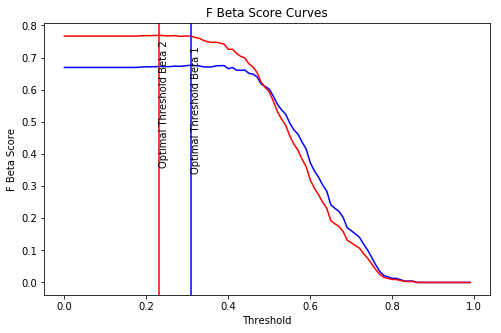

In [387]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, fscores_v1, color='blue')
plt.plot(thresholds, fscores_v2, color='red')
plt.title('F Beta Score Curves')
#plt.legend(('F Beta 1', 'F Beta 2'))
plt.xlabel('Threshold')
plt.axvline(x=best_threshold_v1, color='blue')
plt.text(best_threshold_v1,.71,'Optimal Threshold Beta 1',rotation=90)
plt.axvline(x=best_threshold_v2, color='red')
plt.text(best_threshold_v2,.73,'Optimal Threshold Beta 2',rotation=90)
plt.ylabel('F Beta Score')
plt.show()

In [145]:
recall_score(y_true, adj_class_v1)

0.639344262295082

In [158]:
np.linspace(start = 0, stop = 2, num = 10)

array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ])